In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""flags, file path, and file names for saving data and figures"""

# have data file already?
have_data_file = False  # if True, load data from file
                        # if False, run simulation (and save data)
                        
if have_data_file:
    # load data from this path (including file name)
    data_path = 'YOUR LOCAL DIRECTORY WHERE DATA FILE IS ALREADY SAVED'
else:
    # save simulated data?
    save_data = False      
    # file name for new simulated data to be saved
    filename_data = 'data-ER-EPG-weights_yyyy-mm-dd.npz'

# save simulated data and/or figure panel to this path (excluding file name)
save2path = 'YOUR LOCAL DIRECTORY FOR SAVING FILES'

# save figure panel 1c?
save_fig1c = False
# figure panel file format, e.g. 'pdf', 'eps', 'svg'
fig_format = 'pdf'
# figure panel file name
filename_fig1c = 'fig1c-ER-EPG-weights_yyyy-mm-dd'

In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
from ra_network import RingAttractorNetwork, \
    back_to_circ, movmean, plot_all, sliding_window, offset_variation, \
        generate_ground_truth, generate_ER_input, generate_AV_input_noise, generate_ER_input_noise

In [4]:
# plotting parameters

mpl.rcParams.update({
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16
    })

%matplotlib inline

In [5]:
# ring attractor network parameters

network_params = {
    'N' : 32,                               # number of neurons
    'tau': 0.05,                            # network time constant [s]
    'alpha': -8.93,                         # self-excitation parameter
    'D' : 5.19,                             # nearest-neighbor excitation
    'beta' : 0.11,                          # global inhibition parameter
    'f_act' : lambda x: np.maximum(0,x+1),  # activation function
    'v_rel' : 3.64 ,                        # angular velocity conversion factor
    'dt' : 0.0025                           # step size [s]
    }

In [6]:
"""specify simulation parameters"""

# learning rule parameters
gamma_Hebb = 1          # associative/Hebbian plasticity
gamma_postboost = 1     # non-associative post-synaptic boost
gamma_decay = 17        # activity-dependent weight decay
learning_rate = 5e-5    # learning rate

# ER input noise parameters
ER_baseline_factor = 0.45

# simulation time parameters
T = 240     # [s]

# specify initial weight norm
W_norm_init = 1.5


if have_data_file == False:

    """create ring attractor object"""

    ra = RingAttractorNetwork(network_params)

    ra.gamma_Hebb = gamma_Hebb
    ra.gamma_postboost = gamma_postboost
    ra.gamma_decay = gamma_decay
    ra.eta = learning_rate

    ra.gamma_Hebb_2 = gamma_Hebb
    ra.gamma_postboost_2 = gamma_postboost
    ra.gamma_decay_2 = gamma_decay

    h0, w0 = ra.determine_features_basic()
    ER_baseline = ER_baseline_factor * np.sum(ra.r_init)


    """simulation"""

    # reset network
    ra.reset_network()

    # generate ground truth AV input and HD for learning
    v_AV, z_HD = generate_ground_truth(ra.dt, T)

    # generate ER input associated with cue 1
    g1, _, _ = generate_ER_input(ra, T, v_AV, z_HD)

    # generate ER input associated with cue 2
    g2 = np.copy(g1)

    # generate AV input noise
    noise_AV = generate_AV_input_noise(ra.dt, T)

    # generate ER input noise associated with cue 1
    noise_g1 = generate_ER_input_noise(g1)
    noise_g1 = noise_g1.T / np.sum(noise_g1, axis=1)
    noise_g1 = ER_baseline * noise_g1
    noise_g1 = noise_g1.T

    # generate ER input noise associated with cue 2
    noise_g2 = generate_ER_input_noise(g2)
    noise_g2 = noise_g2.T / np.sum(noise_g2, axis=1)
    noise_g2 = ER_baseline * noise_g2
    noise_g2 = noise_g2.T

    # initialize weight matrix associated with cue 1
    ra.W = np.random.uniform(0, 1, (ra.N, ra.N))
    ra.W = W_norm_init * ra.W / np.linalg.norm(ra.W)

    # initialize weight matrix associated with cue 2
    ra.W2 = np.random.uniform(0, 1, (ra.N, ra.N))
    ra.W2 = W_norm_init * ra.W2 / np.linalg.norm(ra.W2)

    # learn weight matrices
    ra.simulate_two_cues(T, v = v_AV + noise_AV, g = g1 + noise_g1, g2 = g2 + noise_g2, learn=True, trace=True)

    # take weight matrices at final time step
    W1 = ra.W.copy()
    W2 = ra.W2.copy()


    """save data"""

    if save_data:
        np.savez(os.path.join(save2path, filename_data), W1 = W1, W2 = W2)

else:

    """load data"""

    with np.load(data_path) as data_arrays:
        W1 = data_arrays['W1']
        W2 = data_arrays['W2']

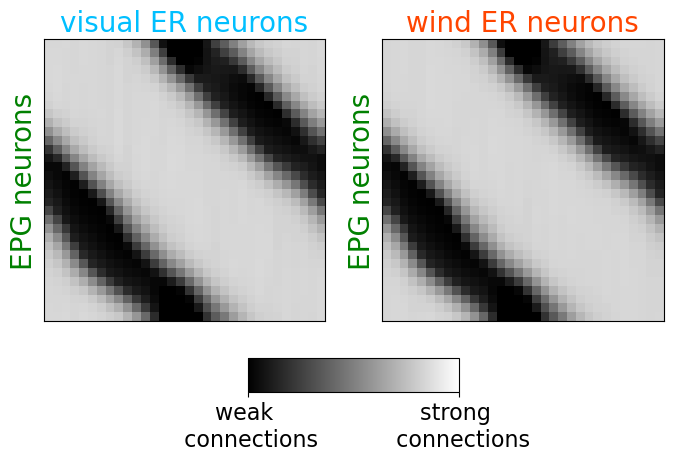

In [7]:
"""visualization"""

plot_fig1c = True

# compute w_max
w_max_1 = gamma_postboost / gamma_decay
w_max_2 = gamma_postboost / gamma_decay

if plot_fig1c:
    fig_1c, ax_1c = plt.subplots(1, 2, figsize=(8, 6))

    # plot ER->EPG weights associated with cue 1 (visual)
    im1 = ax_1c[0].imshow(W1, vmin=0, vmax=w_max_1, aspect='equal', cmap='gray')
    ax_1c[0].set_xticks([])
    ax_1c[0].set_yticks([])
    ax_1c[0].set_ylabel('EPG neurons', color='green')
    ax_1c[0].set_title('visual ER neurons', color='deepskyblue')

    # plot ER->EPG weights associated with cue 2 (wind)
    im2 = ax_1c[1].imshow(W2, vmin=0, vmax=w_max_2, aspect='equal', cmap='gray')
    ax_1c[1].set_xticks([])
    ax_1c[1].set_yticks([])
    ax_1c[1].set_ylabel('EPG neurons', color='green')
    ax_1c[1].set_title('wind ER neurons', color='orangered')

    # plot grayscale bar
    grayscalebar_ax = ax_1c[0].inset_axes([0.725, -0.25, 0.75, 0.12])
    grayscalebar = fig_1c.colorbar(im2, ax=ax_1c.ravel().tolist(), cax=grayscalebar_ax, orientation='horizontal')
    # grayscalebar = fig_1c.colorbar(im2, ax=ax_1c[:], shrink = 0.3, orientation='horizontal', aspect=6)
    grayscalebar.set_ticks([0, w_max_1])
    grayscalebar.set_ticklabels(['weak \n connections', 'strong \n connections'])

In [8]:
"""save figure"""

if save_fig1c:
    fig_1c.savefig(os.path.join(save2path, filename_fig1c + '.' + fig_format), format=fig_format)